In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = '50 percent More hold LSTM Time Series - noncyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from pil import Image
from sklearn import preprocessing
import tensorflow_addons as tfa
import glob
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import math

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Prepare Test Data

In [5]:
nr_test_sets = ['600519.SS','000333.SZ','WMT','FDP']
nr_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
            
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    print(X.shape)
    
    y = to_categorical(y, 3)
    
    nr_test_data['{}_X'.format(name)] = X
    nr_test_data['{}_y'.format(name)] = y

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   686.979980  640.790403 -10.183147  35030093.0     2.0
2019-01-23   671.000000  645.438034 -23.857615  30817872.0     2.0
2019-01-24   665.659973  648.549101 -28.427209  27455391.0     2.0
2019-01-25   672.500000  652.233855 -26.754575  30370918.0     2.0
2019-01-28   679.700012  656.459418 -19.452330  33269553.0     2.0
(207, 15, 4)
            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22    42.090000  39.647816 -10.142844  258783172.0     2.0
2019-01-23    41.299999  39.901998 -21.428571  234314954.0     2.0
2019-01-24    41.459999  40.141691 -19.142859  253542262.0     2.0
2019-01-25    41.590000  40.364507 -19.706827  275498548.0     2.0
2019-01-28    41.900002  40.600737 -14.705848  302253363.0     2.0
(207, 15, 4)
            previous_1d     EMA_12  

In [6]:
r_test_sets = ['600519.SS','000333.SZ','WMT','FDP']
r_test_data = {}

for name in nr_test_sets:

    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    labels = []
    data_15 = []
    sequential = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1
            
    X = sequential
    X  = np.array(X).reshape(-1, 15, 4)
    y = labels
    y = np.array(y)
    print(X.shape)
    
    y = to_categorical(y, 3)
    
    r_test_data['{}_X'.format(name)] = X
    r_test_data['{}_y'.format(name)] = y

            previous_1d       EMA_12   willr_14       OBV_7  labels
Date                                                               
2020-01-22  1075.300049  1097.577291 -89.711935   1200864.0     2.0
2020-01-23  1075.510010  1094.182325 -70.779503   4820868.0     2.0
2020-02-03  1052.800049  1087.815821 -81.895216   -525975.0     1.0
2020-02-04  1003.919983  1074.908769 -83.419991 -12870263.0     2.0
2020-02-05  1038.010010  1069.232037 -59.790669  -6607845.0     2.0
(208, 15, 4)
            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22    58.099998  59.163333 -58.000031  68400881.0     2.0
2020-01-23    57.480000  58.904359 -70.400009  27240262.0     2.0
2020-02-03    55.029999  58.308304 -99.500020 -27633268.0     1.0
2020-02-04    50.189999  57.059334 -94.741468 -98139988.0     2.0
2020-02-05    52.790001  56.402513 -71.954419 -57726889.0     2.0
(208, 15, 4)
            previous_1d      EMA_12 

## Train Accumulation Phase Stock Data

In [7]:
def pred_acc(actual, predictions, logger):

    hold = 0
    sell = 0
    buy = 0
    pred_hold = 0
    pred_sell = 0
    pred_buy = 0
    buy_buy = 0
    buy_sell = 0
    buy_hold = 0
    sell_buy = 0
    sell_sell = 0
    sell_hold = 0
    hold_buy = 0
    hold_sell = 0
    hold_hold = 0

    for i in range (0,len(actual)):
        if actual[i]==1 and predictions[i] == 1:
            buy_buy += 1
            buy += 1
            pred_buy += 1
        elif actual[i]==1 and predictions[i] == 0:
            buy_sell += 1
            buy += 1
            pred_sell += 1
        elif actual[i]==1 and predictions[i] == 2:
            buy_hold += 1
            buy += 1
            pred_hold += 1
        elif actual[i]==0 and predictions[i] == 1:
            sell_buy += 1
            sell += 1
            pred_buy += 1
        elif actual[i]==0 and predictions[i] == 0:
            sell_sell += 1
            sell += 1
            pred_sell += 1
        elif actual[i]==0 and predictions[i] == 2:
            sell_hold += 1
            sell += 1
            pred_hold += 1
        elif actual[i]==2 and predictions[i] == 1:
            hold_buy += 1
            hold += 1
            pred_buy += 1
        elif actual[i]==2 and predictions[i] == 0:
            hold_sell += 1
            hold += 1
            pred_sell += 1
        elif actual[i]==2 and predictions[i] == 2:
            hold_hold += 1
            hold += 1
            pred_hold += 1

    print("number of predictions: " + str(len(actual)))
    print("actual predicted buys: " + str(buy_buy) )
    print("actual buys but predicted sell: " + str(buy_sell) )
    print("actual buys but predicted hold: " + str(buy_hold))
    print("actual sells but predicted buy: " + str(sell_buy) )
    print("actual predicted sells: " + str(sell_sell))
    print("actual sells but predicted hold: " + str(sell_hold) )
    print("actual holds but predicted buy: " + str(hold_buy) )
    print("actual holds but predicted sell: " + str(hold_sell))
    print("actual predicted holds: " + str(hold_hold) )
    
    if pred_buy !=0:
        Percentage_buys_correct = 100*buy_buy/pred_buy
    else:
        Percentage_buys_correct = 0
        
    if pred_sell !=0:
        Percentage_sells_correct = 100*sell_sell/pred_sell
    else:
        Percentage_sells_correct = 0
        
    if pred_hold !=0:
        Percentage_holds_correct = 100*hold_hold/pred_hold
    else:
        Percentage_holds_correct = 0

    print("Percentage buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage holds correct: " + str(Percentage_holds_correct) + "%")

    print("actual buys: " + str(buy))
    print("actual sells: " + str(sell))
    print("actual holds: " + str(hold))
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger


In [8]:
def correct_maxima_minima(predictions, price, logger):
    correct_maxima = 0 
    correct_minima = 0
    correct_hold = 0

    hold = 0
    buy = 0
    sell = 0

#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):
        if i < 4:
            prices = price[i:i+9]
            prices.sort(key = float)
#             if i == 0:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1

        else:
            prices = price[i:i+5]
            prices = prices + price[i-4:i] 
            prices.sort(key = float)
#             if i == 10:
#                 print(prices)
            highest_1 = prices[-1]
            highest_2 = prices[-2]
            highest_3 = prices[-3]
            highest_4 = prices[-4]
            lowest_1 = prices[0]
            lowest_2 = prices[1]
            lowest_3 = prices[2]
            lowest_4 = prices[3]
            if predictions[i] == 0:
                sell += 1
                if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                    correct_maxima += 1
            elif predictions[i] == 1:
                buy += 1
                if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                    correct_minima += 1
            elif predictions[i] == 2:
                hold += 1
                if price[i] != lowest_1 and price[i] != highest_1:
                    correct_hold += 1
                    
    if buy !=0:
        Percentage_buys_correct = 100*correct_minima/buy
    else:
        Percentage_buys_correct = 0
        
    if sell !=0:
        Percentage_sells_correct = 100*correct_maxima/sell
    else:
        Percentage_sells_correct = 0
        
    if hold !=0:
        Percentage_holds_correct = 100*correct_hold/hold
    else:
        Percentage_holds_correct = 0

    print("Percentage low buys correct: " + str(Percentage_buys_correct) + "%")
    print("Percentage high sells correct: " + str(Percentage_sells_correct) + "%")
    print("Percentage mid holds correct: " + str(Percentage_holds_correct) + "%")
    logger.append(Percentage_buys_correct) ; logger.append(Percentage_sells_correct) ; logger.append(Percentage_holds_correct)
    
    return logger

In [9]:
def profit(predictions, price, logger):
    
    price = np.array([price]).reshape(-1, 1)
    min_max_scaler = preprocessing.MinMaxScaler()
    price = min_max_scaler.fit_transform(price)
    price = price.flatten().tolist()
    price = [x + 0.01 for x in price]
    
#     avg_price = sum(price) / len(price)
#     avg_price = int(avg_price)
#     print("Avg price of stocks: " + str(avg_price))
    
#     tens = 1
#     while avg_price >= 10:
#         avg_price /= 10
#         tens += 1
    
    
#     capital = 100*pow(10,tens-1)
    capital = 100
    print("Capital: " + str(capital))
    shares = 0

    previously_buy = False
    previously_sell = False
    prev_buy_price = 0
    bought_once = False


#     predictions = df['predictions'].values.tolist()
#     price = df['previous_1d'].values.tolist()

    for i in range(0,len(predictions)):

#         if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 5 and shares!=0:
#             capital += 0.99725 * (shares*price[i])
#             shares = 0
#             print("Stop Loss Activated!\n")
#             print("Share price: $" + str(price[i]))
#             print("Shares owned at the moment: " + str(shares))
#             print("Cash capital at the moment: $" + str(capital))
#             print("\n")
#             previously_buy = False
#             previously_sell = True

        if predictions[i] == 1 and previously_buy != True:
            shares = math.floor(capital / (price[i]*1.00275))
            capital = capital - shares*price[i]*1.00275
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            prev_buy_price = price[i]*1.00275
            bought_once = True
            previously_buy = True
            previously_sell = False

        elif predictions[i] == 0 and previously_sell != True and shares!=0: #and (price[i]/prev_buy_price-1)*100 >= 2
            capital += 0.99725 * (shares*price[i])
            shares = 0
            print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
            print("Share price: $" + str(price[i]))
            print("Shares owned at the moment: " + str(shares))
            print("Cash capital at the moment: $" + str(capital))
            print("\n")
            previously_buy = False
            previously_sell = True

    if shares!=0:
        capital += 0.99725 * (shares*price[i])

    print('\n')
    print("Capital at the end of test period: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100)
    
    capital = 100
    shares = 0

    shares = math.floor(capital / (price[0]*1.00275))
    capital = capital - shares*price[0]*1.00275
    capital += 0.99725 * (shares*price[-1])

    print('\n')
    print("Capital at the end of test period if Buy and Hold: $" +str(capital))
    print("profit gained: " + str(((capital- 100 )/ 100) * 100 ) + '%') 
    logger.append(((capital- 100 )/ 100) * 100 )
    
    return logger

### Creating Training Data and Model

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2001-09-14     7.142585  7.257483 -41.873824  204624213.0     2.0
2001-09-17     7.224180  7.252359 -51.296847  208479649.0     2.0
2001-09-18     7.132634  7.233940 -72.964156  203965392.0     2.0
2001-09-19     7.214230  7.230908 -59.609037  209378730.0     2.0
2001-09-20     7.347568  7.248855 -37.785092  213725440.0     2.0


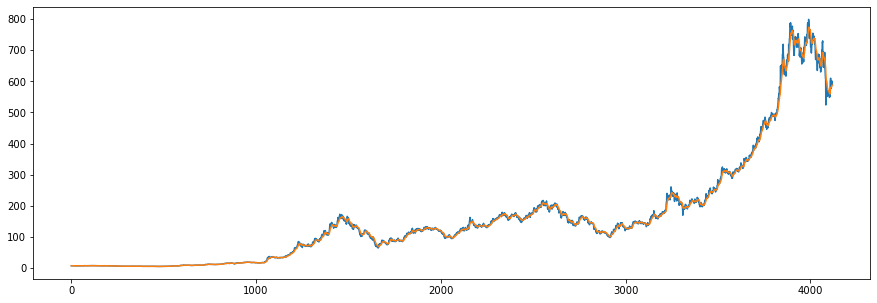

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2013-10-17    11.912000  11.900182 -34.022038  235647532.0     1.0
2013-10-18    11.896000  11.899539 -39.103542  214825024.0     2.0
2013-10-21    12.269333  11.956430 -24.093825  253903732.0     2.0
2013-10-22    12.760000  12.080056  -4.424713  304775737.0     2.0
2013-10-23    12.645333  12.167022 -15.187657  273970459.0     2.0


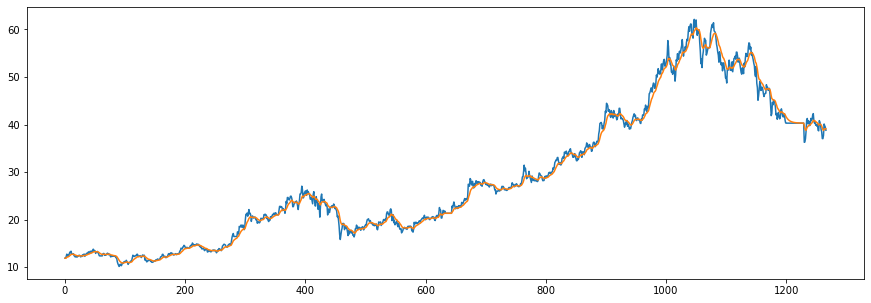

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2000-01-24     4.396951  4.259450 -20.237909   91957609.0     2.0
2000-01-25     4.523540  4.300079 -16.033642  115224048.0     2.0
2000-01-26     4.400991  4.315604 -35.231971  105394663.0     2.0
2000-01-27     4.399644  4.328533 -51.735021   77180955.0     2.0
2000-01-28     4.302682  4.324556 -63.091500   43145413.0     2.0


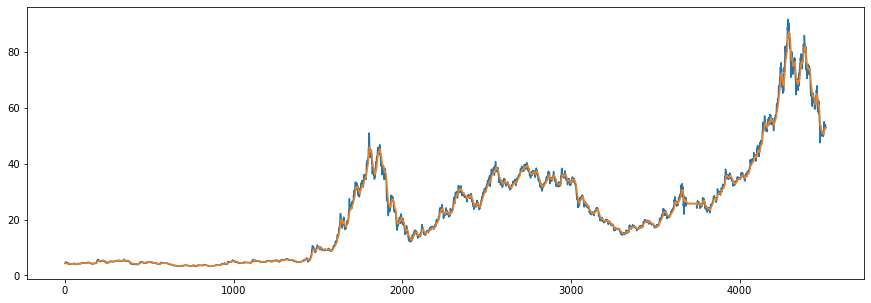

            previous_1d    EMA_12   willr_14        OBV_7  labels
Date                                                             
2004-06-30        2.575  2.436754 -19.047606  495757896.0     2.0
2004-07-01        2.525  2.450330 -33.333298  480565876.0     2.0
2004-07-02        2.525  2.461818 -33.333298  480565876.0     2.0
2004-07-05        2.550  2.475385 -27.777775  505227876.0     2.0
2004-07-06        2.550  2.486864 -27.777775  505227876.0     2.0


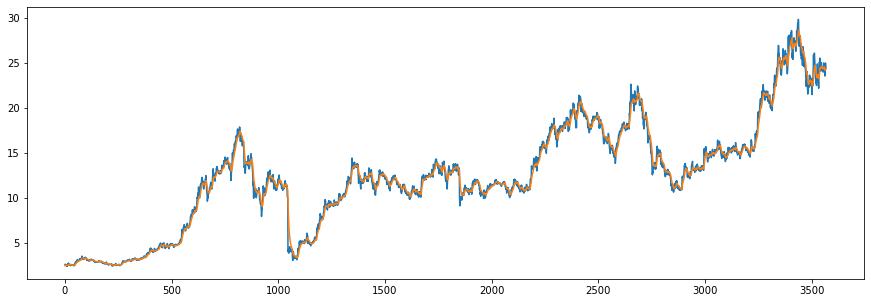

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      50.0000  47.379245 -27.700831  21139400.0     2.0
2000-01-24      48.5000  47.551669 -40.997230  17619200.0     2.0
2000-01-25      47.0000  47.466797 -54.293629  12613700.0     2.0
2000-01-26      49.6875  47.808444 -30.470914  16344500.0     2.0
2000-01-27      50.4375  48.212914 -27.215190  20127300.0     2.0


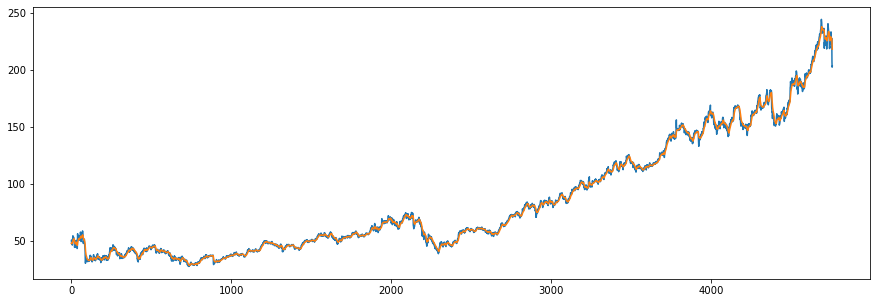

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21     56.28125  56.412106 -36.614173 -25968400.0     2.0
2000-01-24     51.34375  55.632359 -83.112583 -50347200.0     2.0
2000-01-25     51.56250  55.006226 -64.721485 -21792600.0     1.0
2000-01-26     48.75000  54.043730 -88.594164 -38890400.0     2.0
2000-01-27     50.31250  53.469695 -75.331565 -28647200.0     2.0


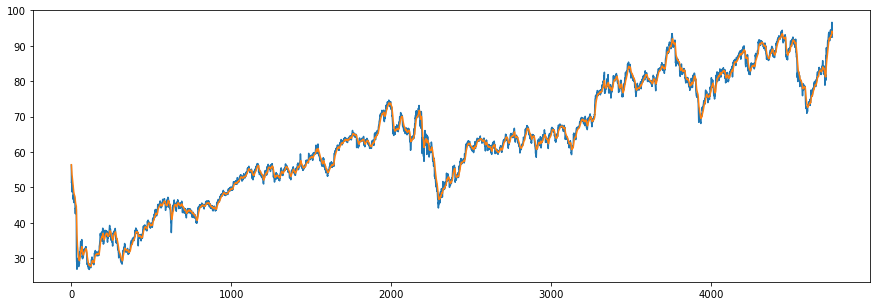

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2000-01-21      63.3750  65.176128 -85.271318 -26649200.0     2.0
2000-01-24      62.4375  64.754801 -94.594595 -33601700.0     2.0
2000-01-25      59.3750  63.927139 -83.606557 -41401600.0     2.0
2000-01-26      61.1250  63.496041 -68.306011 -34997800.0     2.0
2000-01-27      61.9375  63.256265 -61.202186 -30459400.0     2.0


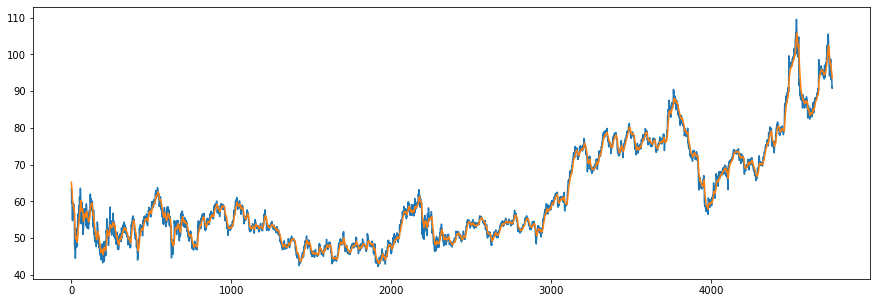

In [10]:
labels = []
sequential = []

train_sets = ['600519.SS','000333.SZ','000858.SZ','2319.HK','COST','PG','WMT']

for name in train_sets:
    seed = 10
    df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data.csv".format(name))
    df.set_index('Date', inplace=True)
    print(df.head())
    
    plt.figure(figsize=(15,5))
    plt.plot(df['previous_1d'].values)
    plt.plot(df['EMA_12'].values)
    plt.show()

    data_15 = []
    count = 0

    for i in df.values:
        if count == 14:
            data_15.append(np.array(i[0:-1]))
            labels.append(i[-1])
            min_max_scaler = preprocessing.MinMaxScaler()
            data_15_arr = min_max_scaler.fit_transform(data_15)
            sequential.append(data_15_arr)
            data_15 = data_15[1:15]
        else:
            data_15.append(np.array(i[0:-1]))
            count+= 1

In [11]:
X = sequential
X  = np.array(X).reshape(-1, 15, 4)
X.shape

(27645, 15, 4)

In [12]:
y = labels
y = np.array(y)
y.shape

(27645,)

In [13]:
from collections import Counter

Counter(y)

Counter({2.0: 25128, 1.0: 1252, 0.0: 1265})

In [14]:
X = sequential
y = labels

class_0 = []
class_1 = []
class_2 = []

class_0_labels = []
class_1_labels = []
class_2_labels = []

for i in range (0,len(y)):
    if y[i] == 0:
        class_0.append(X[i])
        class_0_labels.append(y[i])
    if y[i] == 1:
        class_1.append(X[i])
        class_1_labels.append(y[i])
    if y[i] == 2:
        class_2.append(X[i])
        class_2_labels.append(y[i])
        
class_0 = class_0[0:626]
class_1 = class_1[0:626]
class_2 = class_2[0:1252]

class_0_labels = class_0_labels[0:626]
class_1_labels = class_1_labels[0:626]
class_2_labels = class_2_labels[0:1252]

X = class_0 + class_1 + class_2
y = class_0_labels + class_1_labels + class_2_labels

X  = np.array(X).reshape(-1, 15, 4)
y = np.array(y)

print(X.shape)

Counter(y)

(2504, 15, 4)


Counter({0.0: 626, 1.0: 626, 2.0: 1252})

In [15]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [16]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [17]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [19]:
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa

opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

epochs = 0 
histories = {}
log_hist = {}

epochs = 0 
histories = {}
nr_log_hist = {}
r_log_hist = {}

while epochs < 200:
    
    print('\n\n')
    print("RUNNING EPOCHS {} - {}".format(epochs,epochs+20))
    print('\n\n')
    
    column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
    nr_log  = pd.DataFrame(columns = column_names)
    r_log  = pd.DataFrame(columns = column_names)
    logger = []

    # Train model
    histories['epochs{}-{}'.format(epochs,epochs+20)] = model.fit(
        train_x, train_y,
        batch_size=BATCH_SIZE,
        epochs=20,
        validation_data=(validation_x, validation_y),
        shuffle=True,
        callbacks=[tensorboard],
        class_weight=d_class_weights
    )
    
    score = model.evaluate(validation_x, validation_y, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])
    
    test_sets = ['600519.SS','000333.SZ','WMT','FDP']
    
    for name in test_sets:
        
        print('\n')
        print(name)
        print('\n')
        
        print('Non-Recession Test')
        print('\n')
        
        X = nr_test_data['{}_X'.format(name)]
        y = nr_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(nr_log)
        nr_log.loc[df_length] = logger
        print(nr_log.head(20))
        logger = []
        
        print('Recession Test')
        print('\n')
        
        X = r_test_data['{}_X'.format(name)]
        y = r_test_data['{}_y'.format(name)]

        score = model.evaluate(X, y)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        print('\n')
        logger.append(score[1]) 
        
        predictions = model.predict(X)
        predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
        actual = [np.argmax(i, axis=None, out=None) for i in y]
        
        df = pd.read_csv("data/noncyclic_tickers/initial_indicators/{}_data_test2.csv".format(name))
        df.set_index('Date', inplace=True)
        df = df.iloc[14:]
        df['predictions'] = predictions
        df['actual'] = actual
        df['previous_1d'] = df['previous_1d'].shift(-1)
        df.dropna(inplace=True)
        
        prediction = df['predictions'].values.tolist()
        price = df['previous_1d'].values.tolist()
        
        logger = pred_acc(actual, predictions, logger)
        print('\n')
        logger = correct_maxima_minima(prediction, price, logger)
        print('\n')
        logger = profit(prediction, price, logger)
        
        df_length = len(r_log)
        r_log.loc[df_length] = logger
        print(r_log.head(20))
        logger = []

    nr_log.to_csv('non_recession_{}_{}epochs.csv'.format(experiment,epochs))
    nr_log_hist['{}_epochs_logs'.format(epochs)] = nr_log
    r_log.to_csv('recession_{}_{}epochs.csv'.format(experiment,epochs))
    r_log_hist['{}_epochs_logs'.format(epochs)] = r_log
    epochs = epochs + 20

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 0 1 ... 1 2 0] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "





RUNNING EPOCHS 0 - 20



Epoch 1/20
 1/16 [>.............................] - ETA: 0s - loss: 0.4346 - accuracy: 0.3750 - mse: 0.4675 - weighted_accuracy: 0.2928 - weighted_mse: 0.5161WARNING:tensorflow:From C:\Users\Shearman Chua\anaconda3\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
16/16 [==============================] - 1s 63ms/step - loss: 0.3179 - accuracy: 0.3764 - mse: 0.4570 - weighted_accuracy: 0.3056 - weighted_mse: 0.4851 - val_loss: 0.3014 - val_accuracy: 0.2555 - val_mse: 0.3447 - val_weighted_accuracy: 0.2555 - val_weighted_mse: 0.3447
Epoch 2/20
16/16 [==============================] - 0s 9ms/step - loss: 0.2325 - accuracy: 0.4383 - mse: 0.6065 - weighted_accuracy: 0.4283 - weighted_mse: 0.6086 - val_loss: 0.2976 - val_accuracy: 0.2495 - val_mse: 0.3535 - val_weighted_accuracy: 0.24

7/7 [==============================] - 0s 3ms/step - loss: 0.1936 - accuracy: 0.4279 - mse: 1.0441 - weighted_accuracy: 0.4279 - weighted_mse: 1.0441
Test loss: 0.19356432557106018
Test accuracy: 0.42788460850715637


number of predictions: 208
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 4
actual predicted sells: 4
actual sells but predicted hold: 2
actual holds but predicted buy: 68
actual holds but predicted sell: 44
actual predicted holds: 77
Percentage buys correct: 10.0%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 96.25%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 45.0%
Percentage high sells correct: 54.166666666666664%
Percentage mid holds correct: 84.81012658227849%


Capital: 100
Share price: $0.14442053980990632
Shares owned at the moment: 690
Cash capital at the moment: $0.0757895568753355


Price increase from previously bought: 0.6

7/7 [==============================] - 0s 3ms/step - loss: 0.1989 - accuracy: 0.3077 - mse: 1.0515 - weighted_accuracy: 0.3077 - weighted_mse: 1.0515
Test loss: 0.1989106386899948
Test accuracy: 0.3076923191547394


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 5
actual predicted sells: 0
actual sells but predicted hold: 3
actual holds but predicted buy: 100
actual holds but predicted sell: 34
actual predicted holds: 59
Percentage buys correct: 4.545454545454546%
Percentage sells correct: 0.0%
Percentage holds correct: 92.1875%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 40.36697247706422%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 84.375%


Capital: 100
Share price: $0.15749262821393872
Shares owned at the moment: 633
Cash capital at the moment: $0.033011048013364075


Price increase from previously bought: 17.33712672300

7/7 [==============================] - 0s 3ms/step - loss: 0.2010 - accuracy: 0.2466 - mse: 1.0770 - weighted_accuracy: 0.2466 - weighted_mse: 1.0770
Test loss: 0.20103275775909424
Test accuracy: 0.24657534062862396


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 0
actual buys but predicted hold: 0
actual sells but predicted buy: 5
actual predicted sells: 2
actual sells but predicted hold: 4
actual holds but predicted buy: 129
actual holds but predicted sell: 27
actual predicted holds: 45
Percentage buys correct: 4.964539007092198%
Percentage sells correct: 6.896551724137931%
Percentage holds correct: 91.83673469387755%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 48.57142857142857%
Percentage high sells correct: 51.724137931034484%
Percentage mid holds correct: 89.79591836734694%


Capital: 100
Share price: $0.24286829602432447
Shares owned at the moment: 410
Cash capital at the moment: $0.15016462625953864


Pr

3           5.320149  
Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.2063 - accuracy: 0.1781 - mse: 1.0706 - weighted_accuracy: 0.1781 - weighted_mse: 1.0706
Test loss: 0.20634646713733673
Test accuracy: 0.1780821979045868


number of predictions: 219
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 1
actual sells but predicted buy: 6
actual predicted sells: 3
actual sells but predicted hold: 1
actual holds but predicted buy: 129
actual holds but predicted sell: 43
actual predicted holds: 27
Percentage buys correct: 6.25%
Percentage sells correct: 6.521739130434782%
Percentage holds correct: 93.10344827586206%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 49.65034965034965%
Percentage high sells correct: 56.52173913043478%
Percentage mid holds correct: 89.65517241379311%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: 

16/16 [==============================] - 0s 8ms/step - loss: 0.1349 - accuracy: 0.6485 - mse: 1.5765 - weighted_accuracy: 0.7087 - weighted_mse: 1.5569 - val_loss: 0.1854 - val_accuracy: 0.4571 - val_mse: 1.5181 - val_weighted_accuracy: 0.4571 - val_weighted_mse: 1.5181
Epoch 13/20
16/16 [==============================] - 0s 8ms/step - loss: 0.1336 - accuracy: 0.6495 - mse: 1.5985 - weighted_accuracy: 0.7170 - weighted_mse: 1.5802 - val_loss: 0.1835 - val_accuracy: 0.4651 - val_mse: 1.5453 - val_weighted_accuracy: 0.4651 - val_weighted_mse: 1.5453
Epoch 14/20
16/16 [==============================] - 0s 8ms/step - loss: 0.1336 - accuracy: 0.6645 - mse: 1.5790 - weighted_accuracy: 0.7237 - weighted_mse: 1.5617 - val_loss: 0.1824 - val_accuracy: 0.4651 - val_mse: 1.5035 - val_weighted_accuracy: 0.4651 - val_weighted_mse: 1.5035
Epoch 15/20
16/16 [==============================] - 0s 8ms/step - loss: 0.1323 - accuracy: 0.6675 - mse: 1.6112 - weighted_accuracy: 0.7287 - weighted_mse: 1.5940

7/7 [==============================] - 0s 3ms/step - loss: 0.2085 - accuracy: 0.3269 - mse: 1.6552 - weighted_accuracy: 0.3269 - weighted_mse: 1.6552
Test loss: 0.20851540565490723
Test accuracy: 0.32692307233810425


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 39
actual holds but predicted sell: 95
actual predicted holds: 55
Percentage buys correct: 12.76595744680851%
Percentage sells correct: 6.796116504854369%
Percentage holds correct: 94.82758620689656%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 57.4468085106383%
Percentage high sells correct: 51.45631067961165%
Percentage mid holds correct: 87.71929824561404%


Capital: 100
Share price: $0.12558233818043063
Shares owned at the moment: 794
Cash capital at the moment: $0.013414449321103916


Pric

7/7 [==============================] - 0s 3ms/step - loss: 0.2201 - accuracy: 0.2596 - mse: 1.6907 - weighted_accuracy: 0.2596 - weighted_mse: 1.6907
Test loss: 0.22006115317344666
Test accuracy: 0.25961539149284363


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 2
actual predicted sells: 5
actual sells but predicted hold: 1
actual holds but predicted buy: 46
actual holds but predicted sell: 103
actual predicted holds: 44
Percentage buys correct: 9.433962264150944%
Percentage sells correct: 4.62962962962963%
Percentage holds correct: 93.61702127659575%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 54.716981132075475%
Percentage high sells correct: 54.205607476635514%
Percentage mid holds correct: 82.97872340425532%


Capital: 100
Share price: $0.17308466104252018
Shares owned at the moment: 576
Cash capital at the moment: $0.02906913641702147


Pri

7/7 [==============================] - 0s 3ms/step - loss: 0.2240 - accuracy: 0.2603 - mse: 1.7296 - weighted_accuracy: 0.2603 - weighted_mse: 1.7296
Test loss: 0.22399932146072388
Test accuracy: 0.2602739632129669


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 77
actual holds but predicted sell: 80
actual predicted holds: 44
Percentage buys correct: 6.097560975609756%
Percentage sells correct: 8.98876404494382%
Percentage holds correct: 91.66666666666667%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 50.617283950617285%
Percentage high sells correct: 50.561797752808985%
Percentage mid holds correct: 79.16666666666667%


Capital: 100
Share price: $0.22214604861775533
Shares owned at the moment: 448
Cash capital at the moment: $0.2048862873485291


Price

7/7 [==============================] - 0s 3ms/step - loss: 0.2406 - accuracy: 0.2420 - mse: 1.7070 - weighted_accuracy: 0.2420 - weighted_mse: 1.7070
Test loss: 0.24062597751617432
Test accuracy: 0.24200913310050964


number of predictions: 219
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 2
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 81
actual holds but predicted sell: 78
actual predicted holds: 40
Percentage buys correct: 7.865168539325842%
Percentage sells correct: 7.0588235294117645%
Percentage holds correct: 88.88888888888889%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 53.40909090909091%
Percentage high sells correct: 49.411764705882355%
Percentage mid holds correct: 84.44444444444444%


Capital: 100
Share price: $0.6128949931790368
Shares owned at the moment: 162
Cash capital at the moment: $0.4379663855347644


Pri

Epoch 9/20
16/16 [==============================] - 0s 8ms/step - loss: 0.1210 - accuracy: 0.7054 - mse: 1.7797 - weighted_accuracy: 0.7570 - weighted_mse: 1.7655 - val_loss: 0.1740 - val_accuracy: 0.5569 - val_mse: 1.7193 - val_weighted_accuracy: 0.5569 - val_weighted_mse: 1.7193
Epoch 10/20
16/16 [==============================] - 0s 8ms/step - loss: 0.1190 - accuracy: 0.6985 - mse: 1.7993 - weighted_accuracy: 0.7573 - weighted_mse: 1.7835 - val_loss: 0.1802 - val_accuracy: 0.5329 - val_mse: 1.7674 - val_weighted_accuracy: 0.5329 - val_weighted_mse: 1.7674
Epoch 11/20
16/16 [==============================] - 0s 8ms/step - loss: 0.1193 - accuracy: 0.7069 - mse: 1.8123 - weighted_accuracy: 0.7603 - weighted_mse: 1.7992 - val_loss: 0.1743 - val_accuracy: 0.5529 - val_mse: 1.7899 - val_weighted_accuracy: 0.5529 - val_weighted_mse: 1.7899
Epoch 12/20
16/16 [==============================] - 0s 8ms/step - loss: 0.1180 - accuracy: 0.7074 - mse: 1.8138 - weighted_accuracy: 0.7590 - weighted_

7/7 [==============================] - 0s 3ms/step - loss: 0.2434 - accuracy: 0.3382 - mse: 2.1023 - weighted_accuracy: 0.3382 - weighted_mse: 2.1023
Test loss: 0.24337950348854065
Test accuracy: 0.33816424012184143


number of predictions: 207
actual predicted buys: 7
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 55
actual holds but predicted sell: 75
actual predicted holds: 56
Percentage buys correct: 11.290322580645162%
Percentage sells correct: 8.433734939759036%
Percentage holds correct: 90.3225806451613%
actual buys: 11
actual sells: 10
actual holds: 186


Percentage low buys correct: 61.29032258064516%
Percentage high sells correct: 59.75609756097561%
Percentage mid holds correct: 80.64516129032258%


Capital: 100
Share price: $0.023351977007802775
Shares owned at the moment: 4270
Cash capital at the moment: $0.01284758666803043


P

7/7 [==============================] - 0s 3ms/step - loss: 0.2488 - accuracy: 0.2706 - mse: 2.3769 - weighted_accuracy: 0.2706 - weighted_mse: 2.3769
Test loss: 0.24881336092948914
Test accuracy: 0.2706421911716461


number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 63
actual holds but predicted sell: 90
actual predicted holds: 49
Percentage buys correct: 4.545454545454546%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 90.74074074074075%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 53.03030303030303%
Percentage high sells correct: 47.95918367346939%
Percentage mid holds correct: 81.13207547169812%


Capital: 100
Share price: $0.1092825084279243
Shares owned at the moment: 912
Cash capital at the moment: $0.060271782595805234


Price 

7/7 [==============================] - 0s 3ms/step - loss: 0.2505 - accuracy: 0.3624 - mse: 2.4152 - weighted_accuracy: 0.3624 - weighted_mse: 2.4152
Test loss: 0.2504587173461914
Test accuracy: 0.3623853325843811


number of predictions: 218
actual predicted buys: 8
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 1
actual holds but predicted buy: 62
actual holds but predicted sell: 74
actual predicted holds: 62
Percentage buys correct: 11.428571428571429%
Percentage sells correct: 10.843373493975903%
Percentage holds correct: 95.38461538461539%
actual buys: 10
actual sells: 10
actual holds: 198


Percentage low buys correct: 58.57142857142857%
Percentage high sells correct: 54.21686746987952%
Percentage mid holds correct: 85.9375%


Capital: 100
Share price: $0.2725537450797526
Shares owned at the moment: 365
Cash capital at the moment: $0.24430722426649254


Price increase




RUNNING EPOCHS 60 - 80



Epoch 1/20
16/16 [==============================] - 0s 16ms/step - loss: 0.1113 - accuracy: 0.7344 - mse: 1.9051 - weighted_accuracy: 0.7823 - weighted_mse: 1.8935 - val_loss: 0.1772 - val_accuracy: 0.5689 - val_mse: 1.9854 - val_weighted_accuracy: 0.5689 - val_weighted_mse: 1.9854
Epoch 2/20
16/16 [==============================] - 0s 9ms/step - loss: 0.1115 - accuracy: 0.7369 - mse: 1.9273 - weighted_accuracy: 0.7830 - weighted_mse: 1.9176 - val_loss: 0.1791 - val_accuracy: 0.5689 - val_mse: 1.9624 - val_weighted_accuracy: 0.5689 - val_weighted_mse: 1.9624
Epoch 3/20
16/16 [==============================] - 0s 9ms/step - loss: 0.1096 - accuracy: 0.7349 - mse: 1.9451 - weighted_accuracy: 0.7826 - weighted_mse: 1.9343 - val_loss: 0.1778 - val_accuracy: 0.5808 - val_mse: 2.0377 - val_weighted_accuracy: 0.5808 - val_weighted_mse: 2.0377
Epoch 4/20
16/16 [==============================] - 0s 9ms/step - loss: 0.1096 - accuracy: 0.7429 - mse: 1.9494 - weighted_a

7/7 [==============================] - 0s 3ms/step - loss: 0.2660 - accuracy: 0.3702 - mse: 2.6532 - weighted_accuracy: 0.3702 - weighted_mse: 2.6532
Test loss: 0.2659614682197571
Test accuracy: 0.3701923191547394


number of predictions: 208
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 3
actual holds but predicted buy: 33
actual holds but predicted sell: 90
actual predicted holds: 66
Percentage buys correct: 10.81081081081081%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 90.41095890410959%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 54.054054054054056%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 86.11111111111111%


Capital: 100
Share price: $0.10063732183484929
Shares owned at the moment: 990
Cash capital at the moment: $0.09506627480381269


Price increase fro

1        1245.275482  
Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.2879 - accuracy: 0.3317 - mse: 2.6592 - weighted_accuracy: 0.3317 - weighted_mse: 2.6592
Test loss: 0.28787586092948914
Test accuracy: 0.33173078298568726


number of predictions: 208
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 35
actual holds but predicted sell: 100
actual predicted holds: 58
Percentage buys correct: 10.256410256410257%
Percentage sells correct: 6.542056074766355%
Percentage holds correct: 93.54838709677419%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 56.41025641025641%
Percentage high sells correct: 54.205607476635514%
Percentage mid holds correct: 85.24590163934427%


Capital: 100
Share price: $0.1863590200873636
Shares owned at the moment: 535
Cash capital a

7/7 [==============================] - 0s 3ms/step - loss: 0.2879 - accuracy: 0.3425 - mse: 2.6599 - weighted_accuracy: 0.3425 - weighted_mse: 2.6599
Test loss: 0.28786903619766235
Test accuracy: 0.34246575832366943


number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 3
actual holds but predicted buy: 65
actual holds but predicted sell: 73
actual predicted holds: 63
Percentage buys correct: 5.797101449275362%
Percentage sells correct: 9.876543209876543%
Percentage holds correct: 91.30434782608695%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 50.0%
Percentage high sells correct: 46.91358024691358%
Percentage mid holds correct: 82.6086956521739%


Capital: 100
Share price: $0.22214604861775533
Shares owned at the moment: 448
Cash capital at the moment: $0.2048862873485291


Price increase from

Shares owned at the moment: 0
Cash capital at the moment: $296.75944534183554


Share price: $0.46839312610281314
Shares owned at the moment: 631
Cash capital at the moment: $0.3906035988905501


Price increase from previously bought: 17.901005577369624%
Share price: $0.5537588662962525
Shares owned at the moment: 0
Cash capital at the moment: $348.85153815908524


Share price: $0.535107626985065
Shares owned at the moment: 650
Cash capital at the moment: $0.07507573555716363


Price increase from previously bought: 3.736484750095692%
Share price: $0.5566283719290868
Shares owned at the moment: 0
Cash capital at the moment: $360.8885442746403


Share price: $0.5272166233203295
Shares owned at the moment: 682
Cash capital at the moment: $0.33801239313828546


Price increase from previously bought: 11.123888299866502%
Share price: $0.5874747365287021
Shares owned at the moment: 0
Cash capital at the moment: $399.89397383735354




Capital at the end of test period: $399.89397383735354
pr

Epoch 1/20
16/16 [==============================] - 0s 16ms/step - loss: 0.0961 - accuracy: 0.7913 - mse: 2.1613 - weighted_accuracy: 0.8289 - weighted_mse: 2.1521 - val_loss: 0.1826 - val_accuracy: 0.5689 - val_mse: 2.3099 - val_weighted_accuracy: 0.5689 - val_weighted_mse: 2.3099
Epoch 2/20
16/16 [==============================] - 0s 9ms/step - loss: 0.0968 - accuracy: 0.7808 - mse: 2.1705 - weighted_accuracy: 0.8176 - weighted_mse: 2.1639 - val_loss: 0.1831 - val_accuracy: 0.5729 - val_mse: 2.2952 - val_weighted_accuracy: 0.5729 - val_weighted_mse: 2.2952
Epoch 3/20
16/16 [==============================] - 0s 10ms/step - loss: 0.0947 - accuracy: 0.7963 - mse: 2.1999 - weighted_accuracy: 0.8329 - weighted_mse: 2.1918 - val_loss: 0.1825 - val_accuracy: 0.5729 - val_mse: 2.3581 - val_weighted_accuracy: 0.5729 - val_weighted_mse: 2.3581
Epoch 4/20
16/16 [==============================] - 0s 9ms/step - loss: 0.0945 - accuracy: 0.8003 - mse: 2.2153 - weighted_accuracy: 0.8336 - weighted_m

7/7 [==============================] - 0s 3ms/step - loss: 0.3111 - accuracy: 0.3702 - mse: 2.9858 - weighted_accuracy: 0.3702 - weighted_mse: 2.9858
Test loss: 0.31110289692878723
Test accuracy: 0.3701923191547394


number of predictions: 208
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 38
actual holds but predicted sell: 85
actual predicted holds: 66
Percentage buys correct: 9.30232558139535%
Percentage sells correct: 7.526881720430108%
Percentage holds correct: 91.66666666666667%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 58.13953488372093%
Percentage high sells correct: 49.46236559139785%
Percentage mid holds correct: 85.91549295774648%


Capital: 100
Share price: $0.10063732183484929
Shares owned at the moment: 990
Cash capital at the moment: $0.09506627480381269


Price 

7/7 [==============================] - 0s 3ms/step - loss: 0.3415 - accuracy: 0.3173 - mse: 3.0735 - weighted_accuracy: 0.3173 - weighted_mse: 3.0735
Test loss: 0.3414984941482544
Test accuracy: 0.3173076808452606


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 2
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 40
actual holds but predicted sell: 100
actual predicted holds: 53
Percentage buys correct: 11.11111111111111%
Percentage sells correct: 7.407407407407407%
Percentage holds correct: 96.36363636363636%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 60.0%
Percentage high sells correct: 56.48148148148148%
Percentage mid holds correct: 87.03703703703704%


Capital: 100
Share price: $0.1863590200873636
Shares owned at the moment: 535
Cash capital at the moment: $0.023743544956943197


Price increase from

7/7 [==============================] - 0s 3ms/step - loss: 0.3444 - accuracy: 0.3516 - mse: 3.1253 - weighted_accuracy: 0.3516 - weighted_mse: 3.1253
Test loss: 0.3443719148635864
Test accuracy: 0.35159817337989807


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 2
actual holds but predicted buy: 61
actual holds but predicted sell: 75
actual predicted holds: 65
Percentage buys correct: 4.6875%
Percentage sells correct: 10.714285714285714%
Percentage holds correct: 91.54929577464789%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 47.61904761904762%
Percentage high sells correct: 47.61904761904762%
Percentage mid holds correct: 81.69014084507042%


Capital: 100
Share price: $0.22214604861775533
Shares owned at the moment: 448
Cash capital at the moment: $0.2048862873485291


Price increase f

7/7 [==============================] - 0s 3ms/step - loss: 0.3769 - accuracy: 0.3333 - mse: 3.3066 - weighted_accuracy: 0.3333 - weighted_mse: 3.3066
Test loss: 0.37690454721450806
Test accuracy: 0.3333333432674408


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 53
actual holds but predicted sell: 85
actual predicted holds: 61
Percentage buys correct: 8.474576271186441%
Percentage sells correct: 7.446808510638298%
Percentage holds correct: 92.42424242424242%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 51.724137931034484%
Percentage high sells correct: 52.12765957446808%
Percentage mid holds correct: 83.33333333333333%


Capital: 100
Share price: $0.5273065208166912
Shares owned at the moment: 189
Cash capital at the moment: $0.06500000145088336


Pric

Epoch 4/20
16/16 [==============================] - 0s 9ms/step - loss: 0.0795 - accuracy: 0.8382 - mse: 2.5662 - weighted_accuracy: 0.8652 - weighted_mse: 2.5587 - val_loss: 0.1971 - val_accuracy: 0.5868 - val_mse: 2.7917 - val_weighted_accuracy: 0.5868 - val_weighted_mse: 2.7917
Epoch 5/20
16/16 [==============================] - 0s 8ms/step - loss: 0.0781 - accuracy: 0.8477 - mse: 2.6168 - weighted_accuracy: 0.8718 - weighted_mse: 2.6104 - val_loss: 0.1898 - val_accuracy: 0.5629 - val_mse: 2.7879 - val_weighted_accuracy: 0.5629 - val_weighted_mse: 2.7879
Epoch 6/20
16/16 [==============================] - 0s 8ms/step - loss: 0.0785 - accuracy: 0.8502 - mse: 2.6223 - weighted_accuracy: 0.8728 - weighted_mse: 2.6111 - val_loss: 0.1970 - val_accuracy: 0.5649 - val_mse: 2.7921 - val_weighted_accuracy: 0.5649 - val_weighted_mse: 2.7921
Epoch 7/20
16/16 [==============================] - 0s 8ms/step - loss: 0.0778 - accuracy: 0.8392 - mse: 2.6365 - weighted_accuracy: 0.8672 - weighted_mse

0        1666.892281  
Recession Test


7/7 [==============================] - 0s 4ms/step - loss: 0.3763 - accuracy: 0.3798 - mse: 3.5538 - weighted_accuracy: 0.3798 - weighted_mse: 3.5538
Test loss: 0.37633880972862244
Test accuracy: 0.3798076808452606


number of predictions: 208
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 36
actual holds but predicted sell: 85
actual predicted holds: 68
Percentage buys correct: 9.75609756097561%
Percentage sells correct: 7.526881720430108%
Percentage holds correct: 91.89189189189189%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 63.41463414634146%
Percentage high sells correct: 48.38709677419355%
Percentage mid holds correct: 86.3013698630137%


Capital: 100
Share price: $0.10063732183484929
Shares owned at the moment: 990
Cash capital at th



Share price: $0.5925721139991345
Shares owned at the moment: 23691
Cash capital at the moment: $0.12434082471554575


Price increase from previously bought: -5.596241082199294%
Share price: $0.5609487283761212
Shares owned at the moment: 0
Cash capital at the moment: $13253.014714892515


Share price: $0.5117568249708
Shares owned at the moment: 25826
Cash capital at the moment: $0.03721585197126842


Price increase from previously bought: -17.939863149804125%
Share price: $0.42110320887626185
Shares owned at the moment: 0
Cash capital at the moment: $10845.541306741103


Share price: $0.6066267137655352
Shares owned at the moment: 17829
Cash capital at the moment: $0.25087089613043645


Price increase from previously bought: -7.55237179353977%
Share price: $0.5623542419676231
Shares owned at the moment: 0
Cash capital at the moment: $9998.892563041769


Share price: $0.529325342753107
Shares owned at the moment: 18838
Cash capital at the moment: $0.04032154008564248


Price increase

7/7 [==============================] - 0s 3ms/step - loss: 0.3840 - accuracy: 0.2890 - mse: 3.8750 - weighted_accuracy: 0.2890 - weighted_mse: 3.8750
Test loss: 0.3840051591396332
Test accuracy: 0.2889908254146576


number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 3
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 1
actual holds but predicted buy: 58
actual holds but predicted sell: 89
actual predicted holds: 55
Percentage buys correct: 1.694915254237288%
Percentage sells correct: 7.070707070707071%
Percentage holds correct: 91.66666666666667%
actual buys: 8
actual sells: 8
actual holds: 202


Percentage low buys correct: 52.54237288135593%
Percentage high sells correct: 50.505050505050505%
Percentage mid holds correct: 83.05084745762711%


Capital: 100
Share price: $0.1092825084279243
Shares owned at the moment: 912
Cash capital at the moment: $0.060271782595805234


Price 


Share price: $0.47983993608463327
Shares owned at the moment: 253
Cash capital at the moment: $0.33463848871728885


Price increase from previously bought: -10.977067067128077%
Share price: $0.4283422953430944
Shares owned at the moment: 0
Cash capital at the moment: $108.40722005853522


Share price: $0.5672426980700174
Shares owned at the moment: 190
Cash capital at the moment: $0.33472311549033407


Price increase from previously bought: -5.324158324356409%
Share price: $0.5385186636879575
Shares owned at the moment: 0
Cash capital at the moment: $102.3718932144253


Share price: $0.5758598144651097
Shares owned at the moment: 177
Cash capital at the moment: $0.1644062894099818


Price increase from previously bought: 30.530960668425287%
Share price: $0.7537424551315122
Shares owned at the moment: 0
Cash capital at the moment: $133.20993670765236


Share price: $0.7453303963654399
Shares owned at the moment: 178
Cash capital at the moment: $0.17628692558318448


Price increase from

3           5.320149  
Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.4520 - accuracy: 0.3242 - mse: 3.9920 - weighted_accuracy: 0.3242 - weighted_mse: 3.9920
Test loss: 0.45197269320487976
Test accuracy: 0.32420089840888977


number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 2
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 51
actual holds but predicted sell: 89
actual predicted holds: 59
Percentage buys correct: 8.771929824561404%
Percentage sells correct: 7.142857142857143%
Percentage holds correct: 92.1875%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 51.785714285714285%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 84.375%


Capital: 100
Share price: $0.5273065208166912
Shares owned at the moment: 189
Cash capital at the moment: $0.06500000145088336

Epoch 4/20
16/16 [==============================] - 0s 9ms/step - loss: 0.0649 - accuracy: 0.8917 - mse: 3.1029 - weighted_accuracy: 0.9121 - weighted_mse: 3.0884 - val_loss: 0.2131 - val_accuracy: 0.5828 - val_mse: 3.4385 - val_weighted_accuracy: 0.5828 - val_weighted_mse: 3.4385
Epoch 5/20
16/16 [==============================] - 0s 8ms/step - loss: 0.0635 - accuracy: 0.8922 - mse: 3.1751 - weighted_accuracy: 0.9098 - weighted_mse: 3.1576 - val_loss: 0.2095 - val_accuracy: 0.5729 - val_mse: 3.3593 - val_weighted_accuracy: 0.5729 - val_weighted_mse: 3.3593
Epoch 6/20
16/16 [==============================] - 0s 8ms/step - loss: 0.0642 - accuracy: 0.8937 - mse: 3.1610 - weighted_accuracy: 0.9088 - weighted_mse: 3.1398 - val_loss: 0.2236 - val_accuracy: 0.5808 - val_mse: 3.4420 - val_weighted_accuracy: 0.5808 - val_weighted_mse: 3.4420
Epoch 7/20
16/16 [==============================] - 0s 8ms/step - loss: 0.0635 - accuracy: 0.8897 - mse: 3.1907 - weighted_accuracy: 0.9088 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.4612 - accuracy: 0.3846 - mse: 4.1833 - weighted_accuracy: 0.3846 - weighted_mse: 4.1833
Test loss: 0.4611855745315552
Test accuracy: 0.38461539149284363


number of predictions: 208
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 39
actual holds but predicted sell: 81
actual predicted holds: 69
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 7.865168539325842%
Percentage holds correct: 92.0%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 63.63636363636363%
Percentage high sells correct: 49.438202247191015%
Percentage mid holds correct: 87.83783783783784%


Capital: 100
Share price: $0.10063732183484929
Shares owned at the moment: 990
Cash capital at the moment: $0.09506627480381269


Price increase fr

1        1245.275482  
Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.4902 - accuracy: 0.3462 - mse: 4.3215 - weighted_accuracy: 0.3462 - weighted_mse: 4.3215
Test loss: 0.49018412828445435
Test accuracy: 0.3461538553237915


number of predictions: 208
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 38
actual holds but predicted sell: 95
actual predicted holds: 60
Percentage buys correct: 9.523809523809524%
Percentage sells correct: 7.766990291262136%
Percentage holds correct: 95.23809523809524%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 57.142857142857146%
Percentage high sells correct: 54.36893203883495%
Percentage mid holds correct: 87.09677419354838%


Capital: 100
Share price: $0.1863590200873636
Shares owned at the moment: 535
Cash capital at t

7/7 [==============================] - 0s 3ms/step - loss: 0.5397 - accuracy: 0.3333 - mse: 4.6973 - weighted_accuracy: 0.3333 - weighted_mse: 4.6973
Test loss: 0.539734959602356
Test accuracy: 0.3333333432674408


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 10
actual sells but predicted hold: 1
actual holds but predicted buy: 60
actual holds but predicted sell: 81
actual predicted holds: 60
Percentage buys correct: 4.761904761904762%
Percentage sells correct: 10.989010989010989%
Percentage holds correct: 92.3076923076923%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 51.61290322580645%
Percentage high sells correct: 48.35164835164835%
Percentage mid holds correct: 83.07692307692308%


Capital: 100
Share price: $0.22214604861775533
Shares owned at the moment: 448
Cash capital at the moment: $0.2048862873485291


Price i

7/7 [==============================] - 0s 3ms/step - loss: 0.5658 - accuracy: 0.3059 - mse: 4.8720 - weighted_accuracy: 0.3059 - weighted_mse: 4.8720
Test loss: 0.5657835602760315
Test accuracy: 0.3059360682964325


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 52
actual holds but predicted sell: 92
actual predicted holds: 55
Percentage buys correct: 10.169491525423728%
Percentage sells correct: 6.0606060606060606%
Percentage holds correct: 90.1639344262295%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 51.724137931034484%
Percentage high sells correct: 48.484848484848484%
Percentage mid holds correct: 81.9672131147541%


Capital: 100
Share price: $0.5285652030654422
Shares owned at the moment: 188
Cash capital at the moment: $0.35647361371202635


Pric

Epoch 4/20
16/16 [==============================] - 0s 9ms/step - loss: 0.0526 - accuracy: 0.9171 - mse: 3.8072 - weighted_accuracy: 0.9334 - weighted_mse: 3.7782 - val_loss: 0.2397 - val_accuracy: 0.5788 - val_mse: 4.2669 - val_weighted_accuracy: 0.5788 - val_weighted_mse: 4.2669
Epoch 5/20
16/16 [==============================] - 0s 9ms/step - loss: 0.0507 - accuracy: 0.9271 - mse: 3.8971 - weighted_accuracy: 0.9394 - weighted_mse: 3.8637 - val_loss: 0.2351 - val_accuracy: 0.5988 - val_mse: 3.9582 - val_weighted_accuracy: 0.5988 - val_weighted_mse: 3.9582
Epoch 6/20
16/16 [==============================] - 0s 9ms/step - loss: 0.0518 - accuracy: 0.9241 - mse: 3.8842 - weighted_accuracy: 0.9351 - weighted_mse: 3.8488 - val_loss: 0.2574 - val_accuracy: 0.5848 - val_mse: 4.1704 - val_weighted_accuracy: 0.5848 - val_weighted_mse: 4.1704
Epoch 7/20
16/16 [==============================] - 0s 8ms/step - loss: 0.0512 - accuracy: 0.9181 - mse: 3.9017 - weighted_accuracy: 0.9324 - weighted_mse

7/7 [==============================] - 0s 3ms/step - loss: 0.5445 - accuracy: 0.3846 - mse: 5.0212 - weighted_accuracy: 0.3846 - weighted_mse: 5.0212
Test loss: 0.5444813370704651
Test accuracy: 0.38461539149284363


number of predictions: 208
actual predicted buys: 4
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 37
actual holds but predicted sell: 83
actual predicted holds: 69
Percentage buys correct: 9.523809523809524%
Percentage sells correct: 7.6923076923076925%
Percentage holds correct: 92.0%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 61.904761904761905%
Percentage high sells correct: 49.45054945054945%
Percentage mid holds correct: 87.83783783783784%


Capital: 100
Share price: $0.10063732183484929
Shares owned at the moment: 990
Cash capital at the moment: $0.09506627480381269


Price increase f

7/7 [==============================] - 0s 3ms/step - loss: 0.5725 - accuracy: 0.3510 - mse: 5.2094 - weighted_accuracy: 0.3510 - weighted_mse: 5.2094
Test loss: 0.5724918842315674
Test accuracy: 0.3509615361690521


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 39
actual holds but predicted sell: 94
actual predicted holds: 60
Percentage buys correct: 11.363636363636363%
Percentage sells correct: 7.766990291262136%
Percentage holds correct: 98.36065573770492%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 59.09090909090909%
Percentage high sells correct: 56.310679611650485%
Percentage mid holds correct: 91.66666666666667%


Capital: 100
Share price: $0.1863590200873636
Shares owned at the moment: 535
Cash capital at the moment: $0.023743544956943197


Price

2        9380.979094  
Recession Test


7/7 [==============================] - 0s 3ms/step - loss: 0.6429 - accuracy: 0.3288 - mse: 5.6731 - weighted_accuracy: 0.3288 - weighted_mse: 5.6731
Test loss: 0.6428661346435547
Test accuracy: 0.3287671208381653


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 10
actual sells but predicted hold: 1
actual holds but predicted buy: 61
actual holds but predicted sell: 81
actual predicted holds: 59
Percentage buys correct: 4.6875%
Percentage sells correct: 10.989010989010989%
Percentage holds correct: 92.1875%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 52.38095238095238%
Percentage high sells correct: 49.45054945054945%
Percentage mid holds correct: 82.8125%


Capital: 100
Share price: $0.22214604861775533
Shares owned at the moment: 448
Cash capital at the moment: $0.204886287348529

7/7 [==============================] - 0s 3ms/step - loss: 0.6760 - accuracy: 0.3242 - mse: 5.8467 - weighted_accuracy: 0.3242 - weighted_mse: 5.8467
Test loss: 0.6759676337242126
Test accuracy: 0.32420089840888977


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 52
actual holds but predicted sell: 88
actual predicted holds: 59
Percentage buys correct: 10.169491525423728%
Percentage sells correct: 6.315789473684211%
Percentage holds correct: 90.76923076923077%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 50.0%
Percentage high sells correct: 49.473684210526315%
Percentage mid holds correct: 81.53846153846153%


Capital: 100
Share price: $0.5285652030654422
Shares owned at the moment: 188
Cash capital at the moment: $0.35647361371202635


Price increase f

Epoch 5/20
16/16 [==============================] - 0s 9ms/step - loss: 0.0405 - accuracy: 0.9501 - mse: 4.7609 - weighted_accuracy: 0.9607 - weighted_mse: 4.7079 - val_loss: 0.2663 - val_accuracy: 0.6088 - val_mse: 4.9190 - val_weighted_accuracy: 0.6088 - val_weighted_mse: 4.9190
Epoch 6/20
16/16 [==============================] - 0s 8ms/step - loss: 0.0415 - accuracy: 0.9496 - mse: 4.7310 - weighted_accuracy: 0.9591 - weighted_mse: 4.6740 - val_loss: 0.2914 - val_accuracy: 0.5729 - val_mse: 5.1556 - val_weighted_accuracy: 0.5729 - val_weighted_mse: 5.1556
Epoch 7/20
16/16 [==============================] - 0s 9ms/step - loss: 0.0412 - accuracy: 0.9456 - mse: 4.7887 - weighted_accuracy: 0.9541 - weighted_mse: 4.7422 - val_loss: 0.2780 - val_accuracy: 0.5928 - val_mse: 5.2237 - val_weighted_accuracy: 0.5928 - val_weighted_mse: 5.2237
Epoch 8/20
16/16 [==============================] - 0s 9ms/step - loss: 0.0406 - accuracy: 0.9466 - mse: 4.8883 - weighted_accuracy: 0.9564 - weighted_mse

7/7 [==============================] - 0s 18ms/step - loss: 0.6186 - accuracy: 0.3942 - mse: 5.8436 - weighted_accuracy: 0.3942 - weighted_mse: 5.8436
Test loss: 0.6186100244522095
Test accuracy: 0.39423078298568726


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 38
actual holds but predicted sell: 82
actual predicted holds: 69
Percentage buys correct: 13.333333333333334%
Percentage sells correct: 7.865168539325842%
Percentage holds correct: 93.24324324324324%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 60.0%
Percentage high sells correct: 48.31460674157304%
Percentage mid holds correct: 89.04109589041096%


Capital: 100
Share price: $0.10063732183484929
Shares owned at the moment: 990
Cash capital at the moment: $0.09506627480381269


Price increase f

7/7 [==============================] - 0s 17ms/step - loss: 0.6441 - accuracy: 0.3558 - mse: 6.0694 - weighted_accuracy: 0.3558 - weighted_mse: 6.0694
Test loss: 0.6441209316253662
Test accuracy: 0.35576921701431274


number of predictions: 208
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 40
actual holds but predicted sell: 91
actual predicted holds: 62
Percentage buys correct: 9.090909090909092%
Percentage sells correct: 8.080808080808081%
Percentage holds correct: 95.38461538461539%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 56.81818181818182%
Percentage high sells correct: 55.55555555555556%
Percentage mid holds correct: 89.0625%


Capital: 100
Share price: $0.1863590200873636
Shares owned at the moment: 535
Cash capital at the moment: $0.023743544956943197


Price increase 

7/7 [==============================] - 0s 19ms/step - loss: 0.7353 - accuracy: 0.3379 - mse: 6.6196 - weighted_accuracy: 0.3379 - weighted_mse: 6.6196
Test loss: 0.7353362441062927
Test accuracy: 0.3378995358943939


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 2
actual holds but predicted buy: 60
actual holds but predicted sell: 79
actual predicted holds: 62
Percentage buys correct: 4.761904761904762%
Percentage sells correct: 10.227272727272727%
Percentage holds correct: 91.17647058823529%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 54.83870967741935%
Percentage high sells correct: 50.0%
Percentage mid holds correct: 82.3529411764706%


Capital: 100
Share price: $0.22214604861775533
Shares owned at the moment: 448
Cash capital at the moment: $0.2048862873485291


Price increase from

7/7 [==============================] - 0s 17ms/step - loss: 0.7638 - accuracy: 0.3516 - mse: 6.8111 - weighted_accuracy: 0.3516 - weighted_mse: 6.8111
Test loss: 0.7637872695922852
Test accuracy: 0.35159817337989807


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 51
actual holds but predicted sell: 84
actual predicted holds: 64
Percentage buys correct: 10.344827586206897%
Percentage sells correct: 7.608695652173913%
Percentage holds correct: 92.7536231884058%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 52.63157894736842%
Percentage high sells correct: 51.08695652173913%
Percentage mid holds correct: 84.05797101449275%


Capital: 100
Share price: $0.5285652030654422
Shares owned at the moment: 188
Cash capital at the moment: $0.35647361371202635


Pric

Epoch 6/20
16/16 [==============================] - 0s 15ms/step - loss: 0.0338 - accuracy: 0.9601 - mse: 5.6957 - weighted_accuracy: 0.9670 - weighted_mse: 5.6168 - val_loss: 0.3260 - val_accuracy: 0.5968 - val_mse: 6.0228 - val_weighted_accuracy: 0.5968 - val_weighted_mse: 6.0228
Epoch 7/20
16/16 [==============================] - 0s 15ms/step - loss: 0.0338 - accuracy: 0.9591 - mse: 5.7593 - weighted_accuracy: 0.9657 - weighted_mse: 5.6910 - val_loss: 0.3115 - val_accuracy: 0.6028 - val_mse: 6.0871 - val_weighted_accuracy: 0.6028 - val_weighted_mse: 6.0871
Epoch 8/20
16/16 [==============================] - 0s 15ms/step - loss: 0.0331 - accuracy: 0.9571 - mse: 5.8554 - weighted_accuracy: 0.9647 - weighted_mse: 5.7648 - val_loss: 0.3221 - val_accuracy: 0.5848 - val_mse: 6.3479 - val_weighted_accuracy: 0.5848 - val_weighted_mse: 6.3479
Epoch 9/20
16/16 [==============================] - 0s 14ms/step - loss: 0.0323 - accuracy: 0.9641 - mse: 5.9057 - weighted_accuracy: 0.9710 - weighted

7/7 [==============================] - 0s 5ms/step - loss: 0.6821 - accuracy: 0.4038 - mse: 6.7691 - weighted_accuracy: 0.4038 - weighted_mse: 6.7691
Test loss: 0.6820812225341797
Test accuracy: 0.4038461446762085


number of predictions: 208
actual predicted buys: 6
actual buys but predicted sell: 0
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 7
actual sells but predicted hold: 2
actual holds but predicted buy: 39
actual holds but predicted sell: 79
actual predicted holds: 71
Percentage buys correct: 13.043478260869565%
Percentage sells correct: 8.13953488372093%
Percentage holds correct: 93.42105263157895%
actual buys: 9
actual sells: 10
actual holds: 189


Percentage low buys correct: 60.869565217391305%
Percentage high sells correct: 48.83720930232558%
Percentage mid holds correct: 89.33333333333333%


Capital: 100
Share price: $0.10063732183484929
Shares owned at the moment: 990
Cash capital at the moment: $0.09506627480381269


Price

7/7 [==============================] - 0s 5ms/step - loss: 0.7053 - accuracy: 0.3798 - mse: 7.0349 - weighted_accuracy: 0.3798 - weighted_mse: 7.0349
Test loss: 0.7053086757659912
Test accuracy: 0.3798076808452606


number of predictions: 208
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 1
actual sells but predicted buy: 0
actual predicted sells: 8
actual sells but predicted hold: 0
actual holds but predicted buy: 39
actual holds but predicted sell: 88
actual predicted holds: 66
Percentage buys correct: 11.363636363636363%
Percentage sells correct: 8.24742268041237%
Percentage holds correct: 98.50746268656717%
actual buys: 7
actual sells: 8
actual holds: 193


Percentage low buys correct: 56.81818181818182%
Percentage high sells correct: 55.670103092783506%
Percentage mid holds correct: 90.9090909090909%


Capital: 100
Share price: $0.1863590200873636
Shares owned at the moment: 535
Cash capital at the moment: $0.023743544956943197


Price i

7/7 [==============================] - 0s 5ms/step - loss: 0.8281 - accuracy: 0.3470 - mse: 7.7535 - weighted_accuracy: 0.3470 - weighted_mse: 7.7535
Test loss: 0.8281164765357971
Test accuracy: 0.34703195095062256


number of predictions: 219
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 9
actual sells but predicted hold: 2
actual holds but predicted buy: 64
actual holds but predicted sell: 73
actual predicted holds: 64
Percentage buys correct: 4.477611940298507%
Percentage sells correct: 10.975609756097562%
Percentage holds correct: 91.42857142857143%
actual buys: 7
actual sells: 11
actual holds: 201


Percentage low buys correct: 54.54545454545455%
Percentage high sells correct: 51.21951219512195%
Percentage mid holds correct: 84.28571428571429%


Capital: 100
Share price: $0.22214604861775533
Shares owned at the moment: 448
Cash capital at the moment: $0.2048862873485291


Price

7/7 [==============================] - 0s 5ms/step - loss: 0.8643 - accuracy: 0.3425 - mse: 7.9436 - weighted_accuracy: 0.3425 - weighted_mse: 7.9436
Test loss: 0.8643124103546143
Test accuracy: 0.34246575832366943


number of predictions: 219
actual predicted buys: 6
actual buys but predicted sell: 1
actual buys but predicted hold: 3
actual sells but predicted buy: 1
actual predicted sells: 6
actual sells but predicted hold: 3
actual holds but predicted buy: 51
actual holds but predicted sell: 85
actual predicted holds: 63
Percentage buys correct: 10.344827586206897%
Percentage sells correct: 6.521739130434782%
Percentage holds correct: 91.30434782608695%
actual buys: 10
actual sells: 10
actual holds: 199


Percentage low buys correct: 52.63157894736842%
Percentage high sells correct: 51.08695652173913%
Percentage mid holds correct: 82.6086956521739%


Capital: 100
Share price: $0.5285652030654422
Shares owned at the moment: 188
Cash capital at the moment: $0.35647361371202635


Price

In [20]:
df = nr_log_hist['0_epochs_logs']
df['Profit gained']

0    1425.520513
1    1140.597971
2    8275.160395
3      20.044879
Name: Profit gained, dtype: float64

In [21]:
kweichow_acc = []
midea_acc = []
walmart_acc = []
FDP_acc = []

kweichow_correct_buys = []
midea_correct_buys = []
walmart_correct_buys = []
FDP_correct_buys = []

kweichow_correct_sells = []
midea_correct_sells = []
walmart_correct_sells = []
FDP_correct_sells = []

kweichow_correct_holds = []
midea_correct_holds = []
walmart_correct_holds = []
FDP_correct_holds = []

kweichow_correct_low_buys = []
midea_correct_low_buys = []
walmart_correct_low_buys = []
FDP_correct_low_buys = []

kweichow_correct_high_sells = []
midea_correct_high_sells = []
walmart_correct_high_sells = []
FDP_correct_high_sells = []

kweichow_correct_mid_holds = []
midea_correct_mid_holds = []
walmart_correct_mid_holds = []
FDP_correct_mid_holds = []

kweichow_profit = []
midea_profit = []
walmart_profit = []
FDP_profit = []

for key,value in nr_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    kweichow_acc.append(acc[0])
    midea_acc.append(acc[1])
    walmart_acc.append(acc[2])
    FDP_acc.append(acc[3]) 

    kweichow_correct_buys.append(correct_buys[0])
    midea_correct_buys.append(correct_buys[1]) 
    walmart_correct_buys.append(correct_buys[2]) 
    FDP_correct_buys.append(correct_buys[3]) 

    kweichow_correct_sells.append(correct_sells[0]) 
    midea_correct_sells.append(correct_sells[1]) 
    walmart_correct_sells.append(correct_sells[2]) 
    FDP_correct_sells.append(correct_sells[3]) 

    kweichow_correct_holds.append(correct_holds[0]) 
    midea_correct_holds.append(correct_holds[1])  
    walmart_correct_holds.append(correct_holds[2])  
    FDP_correct_holds.append(correct_holds[3])  

    kweichow_correct_low_buys.append(correct_low_buys[0])  
    midea_correct_low_buys.append(correct_low_buys[1])  
    walmart_correct_low_buys.append(correct_low_buys[2])  
    FDP_correct_low_buys.append(correct_low_buys[3])   

    kweichow_correct_high_sells.append(correct_high_sells[0]) 
    midea_correct_high_sells.append(correct_high_sells[1]) 
    walmart_correct_high_sells.append(correct_high_sells[2]) 
    FDP_correct_high_sells.append(correct_high_sells[3])     

    kweichow_correct_mid_holds.append(correct_mid_holds[0])  
    midea_correct_mid_holds.append(correct_mid_holds[1])  
    walmart_correct_mid_holds.append(correct_mid_holds[2])   
    FDP_correct_mid_holds.append(correct_mid_holds[3])   

    kweichow_profit.append(profit[0]) 
    midea_profit.append(profit[1]) 
    walmart_profit.append(profit[2]) 
    FDP_profit.append(profit[3])  

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


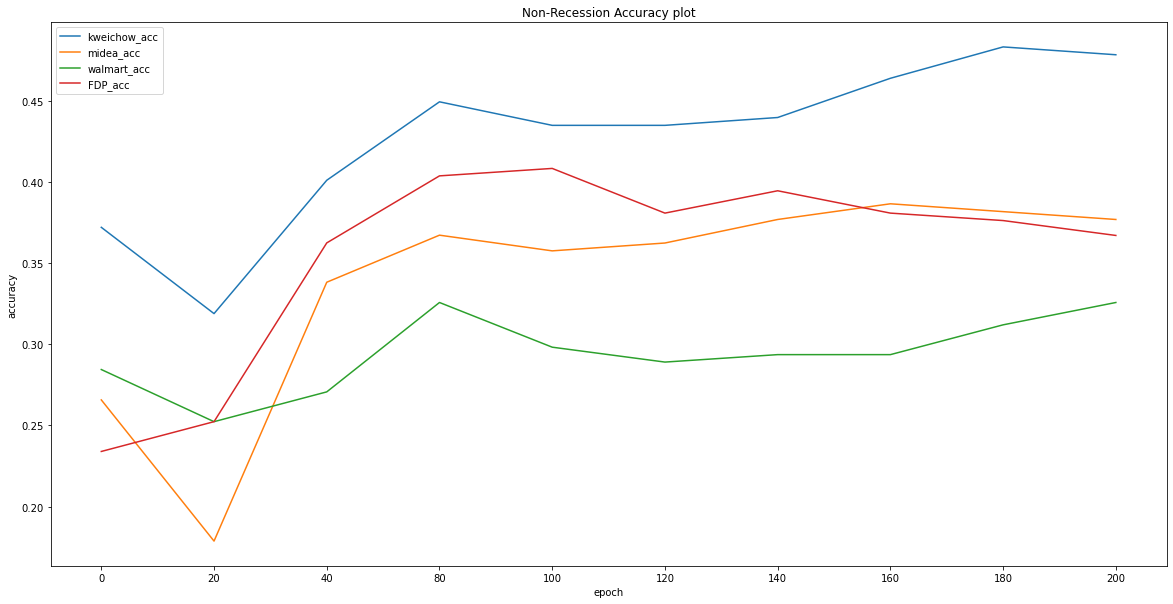

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(kweichow_acc)
plt.plot(midea_acc)
plt.plot(walmart_acc)
plt.plot(FDP_acc)
plt.title('Non-Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['kweichow_acc','midea_acc','walmart_acc','FDP_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'FDP_correct_buys')

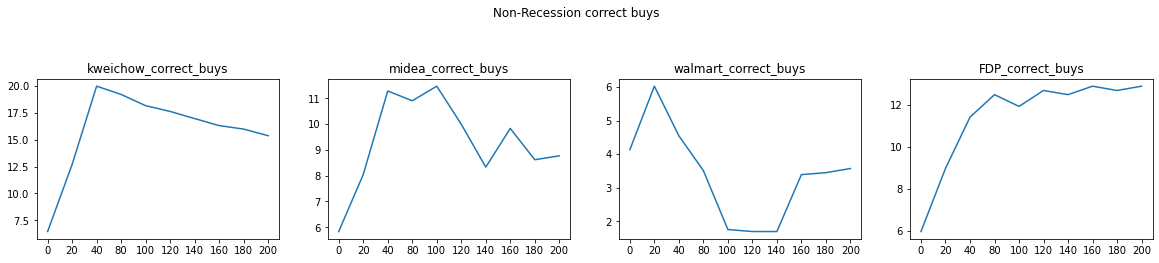

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_buys")

Text(0.5, 1.0, 'FDP_correct_sells')

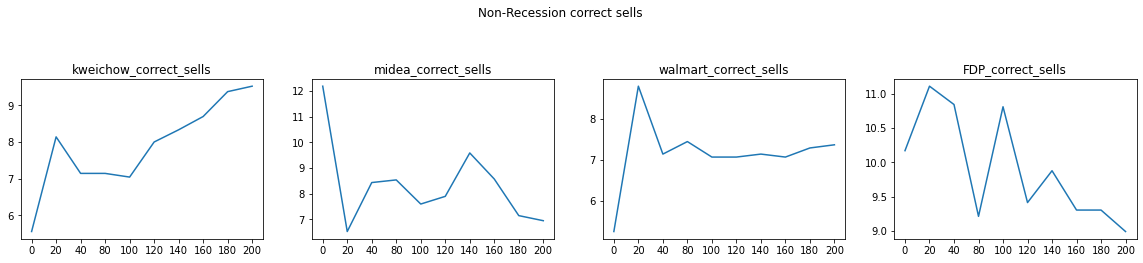

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_sells")

Text(0.5, 1.0, 'FDP_correct_holds')

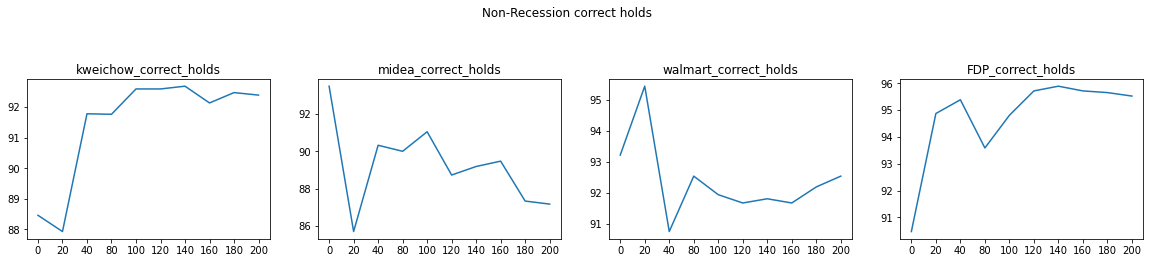

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_holds")

Text(0.5, 1.0, 'FDP_correct_low_buys')

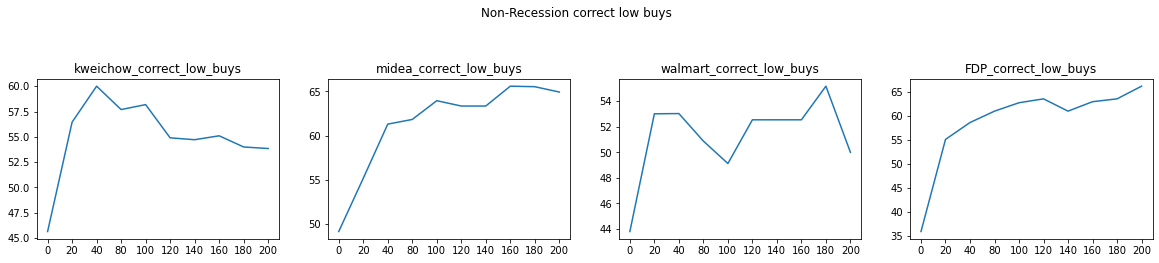

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_low_buys")

Text(0.5, 1.0, 'FDP_correct_high_sells')

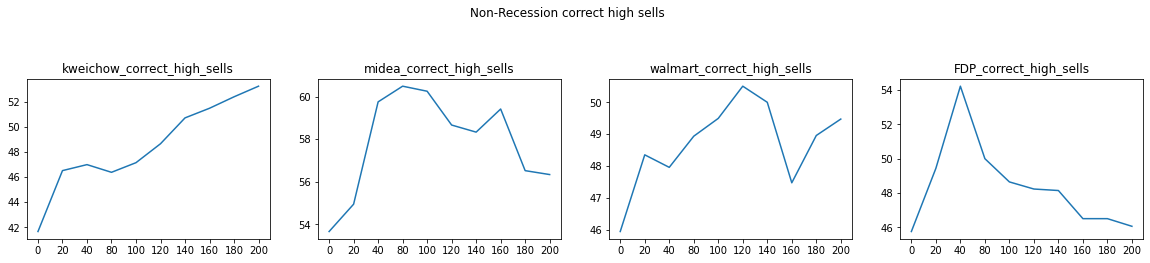

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_high_sells")

Text(0.5, 1.0, 'FDP_correct_mid_holds')

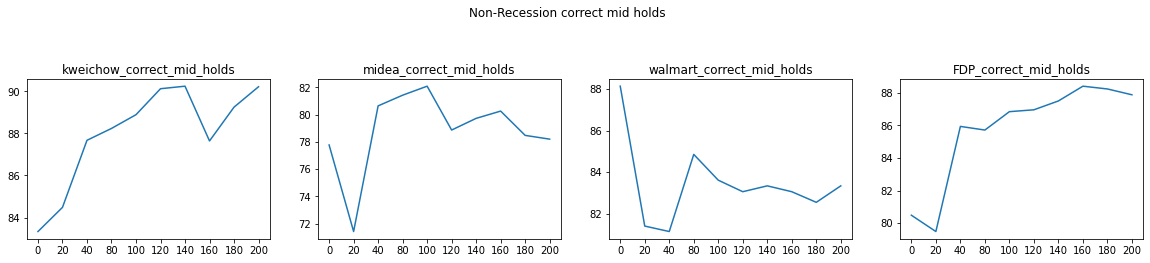

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_mid_holds")

Text(0.5, 1.0, 'FDP_profit')

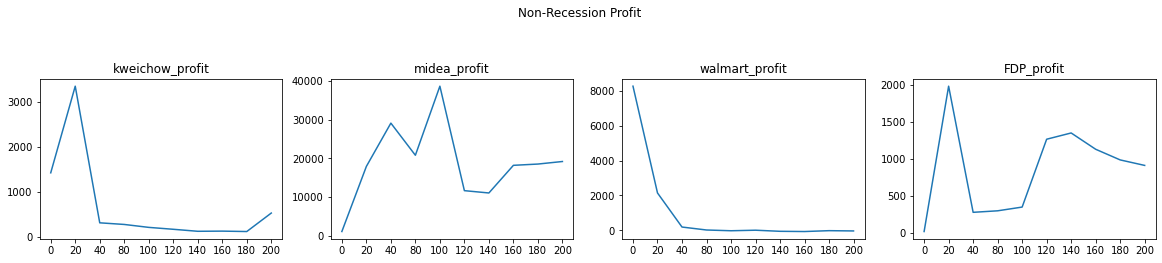

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Non-Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(kweichow_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_profit")

plt.subplot(3, 4, 2)
plt.plot(midea_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_profit")

plt.subplot(3, 4, 3)
plt.plot(walmart_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_profit")

plt.subplot(3, 4, 4)
plt.plot(FDP_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_profit")

In [30]:
kweichow_acc = []
midea_acc = []
walmart_acc = []
FDP_acc = []

kweichow_correct_buys = []
midea_correct_buys = []
walmart_correct_buys = []
FDP_correct_buys = []

kweichow_correct_sells = []
midea_correct_sells = []
walmart_correct_sells = []
FDP_correct_sells = []

kweichow_correct_holds = []
midea_correct_holds = []
walmart_correct_holds = []
FDP_correct_holds = []

kweichow_correct_low_buys = []
midea_correct_low_buys = []
walmart_correct_low_buys = []
FDP_correct_low_buys = []

kweichow_correct_high_sells = []
midea_correct_high_sells = []
walmart_correct_high_sells = []
FDP_correct_high_sells = []

kweichow_correct_mid_holds = []
midea_correct_mid_holds = []
walmart_correct_mid_holds = []
FDP_correct_mid_holds = []

kweichow_profit = []
midea_profit = []
walmart_profit = []
FDP_profit = []

for key,value in r_log_hist.items():
    print(key)
    df = value
    acc = df['Test_accuracy'].values.tolist()
    correct_buys = df['correct_buys'].values.tolist()
    correct_sells = df['correct_sells'].values.tolist()
    correct_holds = df['correct_holds'].values.tolist()
    correct_low_buys = df['correct_low_buys'].values.tolist()
    correct_high_sells = df['correct_high_sells'].values.tolist()
    correct_mid_holds = df['correct_mid_holds'].values.tolist()
    profit = df['Profit gained'].values.tolist()
    
    kweichow_acc.append(acc[0])
    midea_acc.append(acc[1])
    walmart_acc.append(acc[2])
    FDP_acc.append(acc[3]) 

    kweichow_correct_buys.append(correct_buys[0])
    midea_correct_buys.append(correct_buys[1]) 
    walmart_correct_buys.append(correct_buys[2]) 
    FDP_correct_buys.append(correct_buys[3]) 
    
    kweichow_correct_sells.append(correct_sells[0]) 
    midea_correct_sells.append(correct_sells[1]) 
    walmart_correct_sells.append(correct_sells[2]) 
    FDP_correct_sells.append(correct_sells[3]) 

    kweichow_correct_holds.append(correct_holds[0]) 
    midea_correct_holds.append(correct_holds[1])  
    walmart_correct_holds.append(correct_holds[2])  
    FDP_correct_holds.append(correct_holds[3])  

    kweichow_correct_low_buys.append(correct_low_buys[0])  
    midea_correct_low_buys.append(correct_low_buys[1])  
    walmart_correct_low_buys.append(correct_low_buys[2])  
    FDP_correct_low_buys.append(correct_low_buys[3])   

    kweichow_correct_high_sells.append(correct_high_sells[0]) 
    midea_correct_high_sells.append(correct_high_sells[1]) 
    walmart_correct_high_sells.append(correct_high_sells[2]) 
    FDP_correct_high_sells.append(correct_high_sells[3]) 

    kweichow_correct_mid_holds.append(correct_mid_holds[0])  
    midea_correct_mid_holds.append(correct_mid_holds[1])  
    walmart_correct_mid_holds.append(correct_mid_holds[2])   
    FDP_correct_mid_holds.append(correct_mid_holds[3])   

    kweichow_profit.append(profit[0]) 
    midea_profit.append(profit[1]) 
    walmart_profit.append(profit[2]) 
    FDP_profit.append(profit[3])

0_epochs_logs
20_epochs_logs
40_epochs_logs
60_epochs_logs
80_epochs_logs
100_epochs_logs
120_epochs_logs
140_epochs_logs
160_epochs_logs
180_epochs_logs


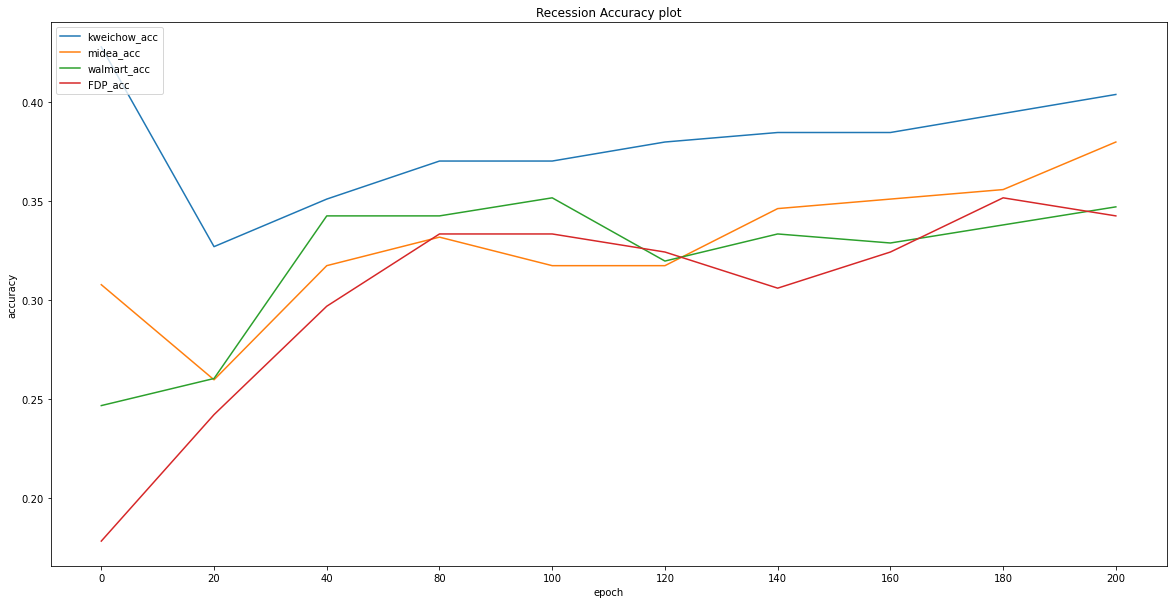

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
labels=[0,20,40,80,100,120,140,160,180,200]
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.plot(kweichow_acc)
plt.plot(midea_acc)
plt.plot(walmart_acc)
plt.plot(FDP_acc)
plt.title('Recession Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['kweichow_acc','midea_acc','walmart_acc','FDP_acc'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'FDP_correct_buys')

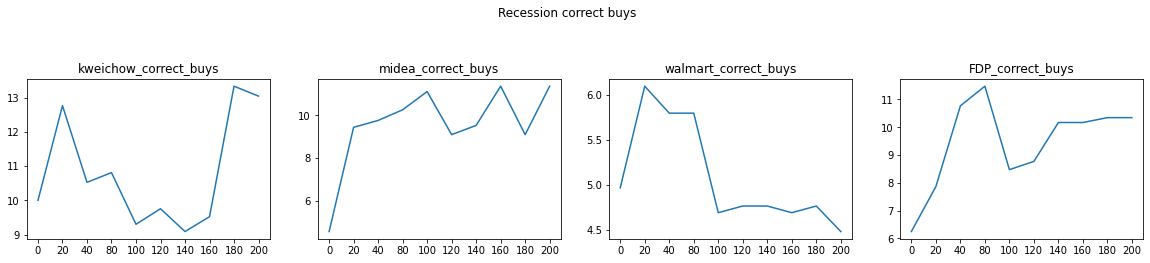

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct buys")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_buys")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_buys")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_buys")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_buys")

Text(0.5, 1.0, 'FDP_correct_sells')

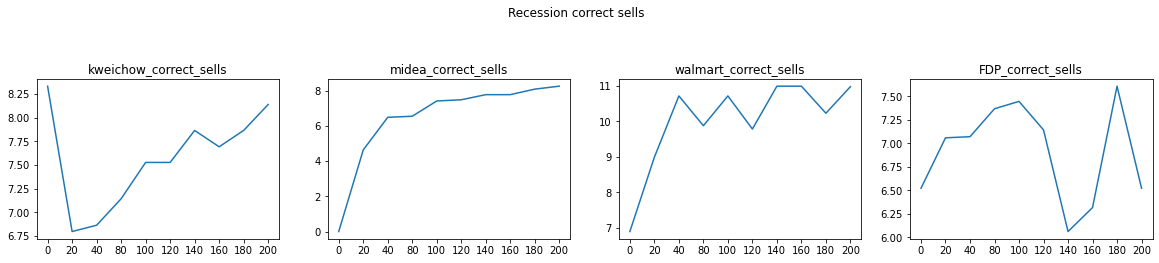

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct sells")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_sells")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_sells")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_sells")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_sells")

Text(0.5, 1.0, 'FDP_correct_holds')

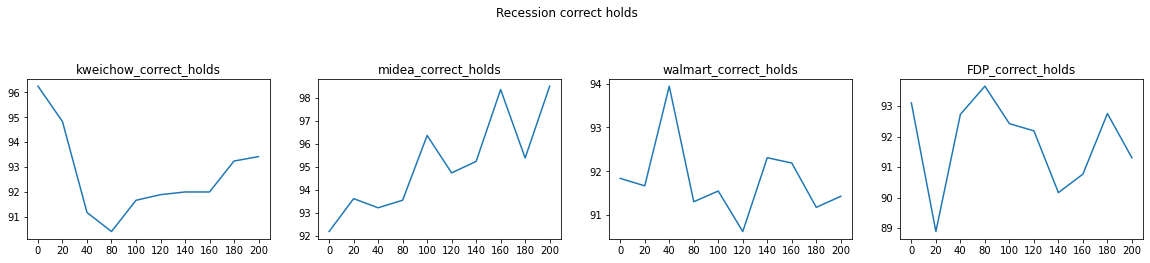

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct holds")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_holds")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_holds")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_holds")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_holds")

Text(0.5, 1.0, 'FDP_correct_low_buys')

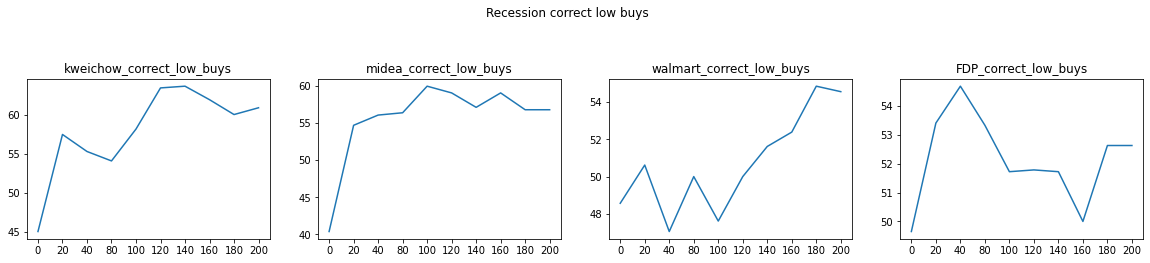

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct low buys")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_low_buys")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_low_buys")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_low_buys")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_low_buys)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_low_buys")

Text(0.5, 1.0, 'FDP_correct_high_sells')

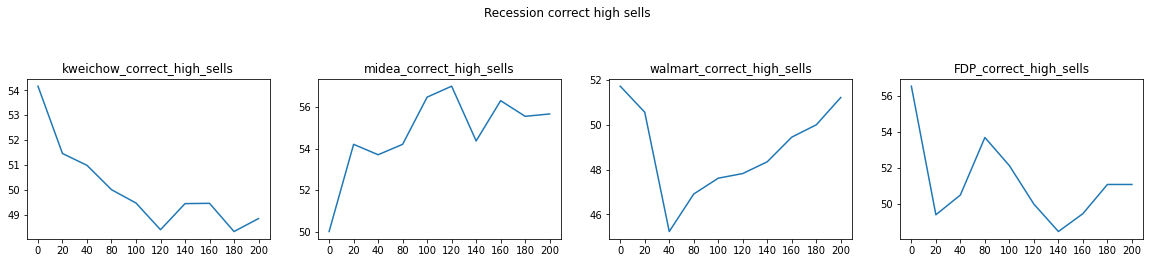

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct high sells")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_high_sells")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_high_sells")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_high_sells")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_high_sells)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_high_sells")

Text(0.5, 1.0, 'FDP_correct_mid_holds')

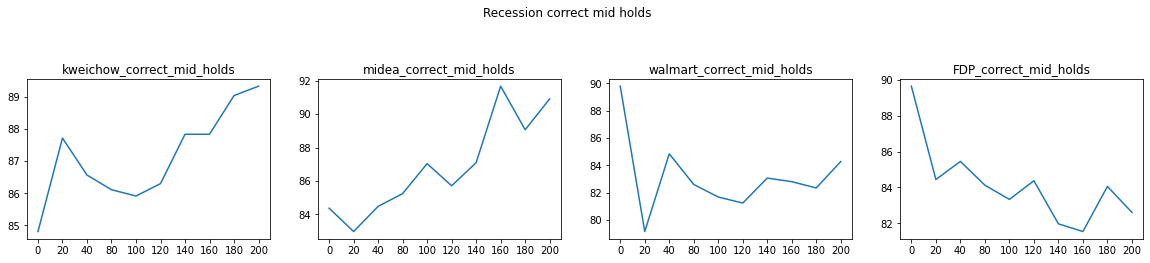

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession correct mid holds")

plt.subplot(3, 4, 1)
plt.plot(kweichow_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_correct_mid_holds")

plt.subplot(3, 4, 2)
plt.plot(midea_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_correct_mid_holds")

plt.subplot(3, 4, 3)
plt.plot(walmart_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_correct_mid_holds")

plt.subplot(3, 4, 4)
plt.plot(FDP_correct_mid_holds)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_correct_mid_holds")

Text(0.5, 1.0, 'FDP_profit')

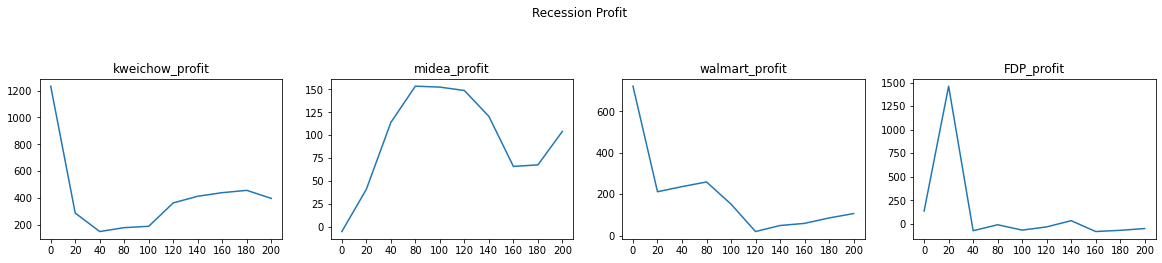

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.suptitle("Recession Profit")

plt.subplot(3, 4, 1)
plt.plot(kweichow_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("kweichow_profit")

plt.subplot(3, 4, 2)
plt.plot(midea_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("midea_profit")

plt.subplot(3, 4, 3)
plt.plot(walmart_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("walmart_profit")

plt.subplot(3, 4, 4)
plt.plot(FDP_profit)
plt.xticks(np.arange(10), (0,20,40,80,100,120,140,160,180,200))
plt.title("FDP_profit")